# Model training

The input data for our analysis includes various features related to typhoon characteristics, such as wind speed and rainfall, as well as population data, the number of houses in the area, topography data, and a few more info. 

We train our made model which is XGBoost Reduced Overfitting on this dataset. This model was specifically designed to prevent overfitting and improve the accuracy of our predictions.

To evaluate the performance of our model, we calculated the root mean square error (RMSE) for the entire dataset as well as for each individual bin. This allowed us to assess how well our model was able to predict the impact of typhoons on different grid cells.

In [1]:
%load_ext jupyter_black

In [2]:
from collections import defaultdict
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import colorama
from colorama import Fore

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = get_training_dataset()

In [4]:
# Check rows including NaN values in the entire df
df.isnull().sum()

typhoon_name                        0
typhoon_year                        0
grid_point_id                       0
wind_speed                          0
track_distance                      0
rainfall_max_6h                     0
rainfall_max_24h                    0
total_houses                        0
rwi                              8736
mean_slope                          0
std_slope                           0
mean_tri                            0
std_tri                             0
mean_elev                           0
coast_length                        0
with_coast                          0
urban                               0
rural                               0
water                               0
total_pop                           0
percent_houses_damaged              0
percent_houses_damaged_5years       0
dtype: int64

In [5]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

In [6]:
# Number of damaged values greater than 100
(df["percent_houses_damaged"] > 100).sum()

3

In [7]:
# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

array([[<AxesSubplot:title={'center':'percent_houses_damaged'}>]],
      dtype=object)

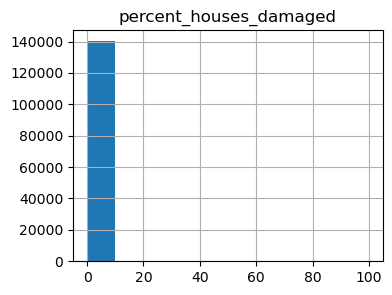

In [8]:
# Show histogram of damage
df.hist(column="percent_houses_damaged", figsize=(4, 3))

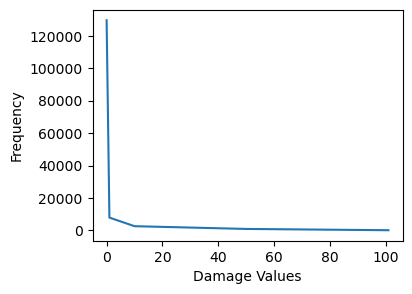

In [9]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [10]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [11]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0.0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0.0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0.0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0.0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0.0


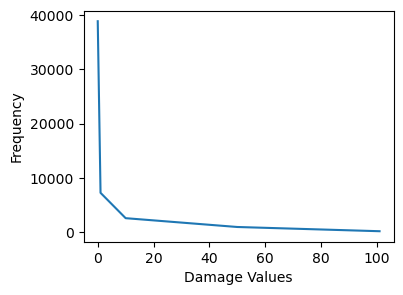

In [12]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [13]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [14]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [15]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [16]:
y_input_strat = bin_index2

In [17]:
# Defin two lists to save total RMSE of test and train data

test_RMSE = defaultdict(list)
train_RMSE = defaultdict(list)

In [18]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [19]:
# Run XGBoost Reduced Overfitting in for loop to estimate RMSE per bins

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_test, y_test)]
    xgb_model = xgb.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
    )

    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    X2_test = sm.add_constant(X_test)

    y_pred_train_LREG = est2.predict(X2)
    mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
    rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

    ypred_LREG = est2.predict(X2_test)
    mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
    rmse_LREG = np.sqrt(mse_idx_LREG)

    print("----- Training ------")
    print(f"LREG Root mean squared error: {rmse_train_LREG:.2f}")
    print("----- Test ------")
    print(f"LREG Root mean squared error: {rmse_LREG:.2f}")

    # Calculate RMSE in total

    y_pred_train = xgb.predict(X_train)

    # Clip the predicted values to be within the range of zero to 100
    y_pred_train_clipped = y_pred_train.clip(0, 100)
    mse_train_idx = mean_squared_error(y_train, y_pred_train_clipped)
    rmse_train = np.sqrt(mse_train_idx)

    y_pred = xgb.predict(X_test)

    # Clip the predicted values to be within the range of zero to 100
    y_pred_clipped = y_pred.clip(0, 100)
    mse_idx = mean_squared_error(y_test, y_pred_clipped)
    rmse = np.sqrt(mse_idx)

    print("----- Training ------")
    print(f"Root mean squared error: {rmse_train:.2f}")

    print("----- Test ------")
    print(f"Root mean squared error: {rmse:.2f}")

    test_RMSE["all"].append(rmse)
    train_RMSE["all"].append(rmse_train)

    # Calculate RMSE per bins

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    for bin_num in range(1, 6):

        mse_train_idx = mean_squared_error(
            y_train[bin_index_train == bin_num],
            y_pred_train_clipped[bin_index_train == bin_num],
        )
        rmse_train = np.sqrt(mse_train_idx)

        mse_idx = mean_squared_error(
            y_test[bin_index_test == bin_num],
            y_pred_clipped[bin_index_test == bin_num],
        )
        rmse = np.sqrt(mse_idx)

        train_RMSE[bin_num].append(rmse_train)
        test_RMSE[bin_num].append(rmse)

[14:05:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.205
Model:                                OLS   Adj. R-squared:                  0.205
Method:                     Least Squares   F-statistic:                     605.2
Date:                    Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                            14:05:07   Log-Likelihood:            -1.1648e+05
No. Observations:                   39803   AIC:                 

In [20]:
# Define a function to plot RMSEs
def rmse_bin_plot(te_rmse, tr_rmse, min_rg, max_rg, step):

    m_test_rmse = statistics.mean(te_rmse)
    plt.figure(figsize=(4, 3))
    plt.axvline(m_test_rmse, color="red", linestyle="dashed")
    plt.hist(
        te_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )
    sd_test_rmse = statistics.stdev(te_rmse)

    m_train_rmse = statistics.mean(tr_rmse)
    plt.axvline(m_train_rmse, color="b", linestyle="dashed")
    plt.hist(
        tr_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )
    sd_train_rmse = statistics.stdev(tr_rmse)

    print(Fore.RED)
    print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
    print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

    print(f"mean_RMSE_test: {m_test_rmse:.2f}")
    print(f"mean_RMSE_train: {m_train_rmse:.2f}")

    # create legend
    labels = ["Mean_test", "Mean_train", "test", "train"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

## Plot RMSE in total

RMSE in total 


stdev_RMSE_test: 0.17
stdev_RMSE_train: 0.05
mean_RMSE_test: 3.25
mean_RMSE_train: 2.60


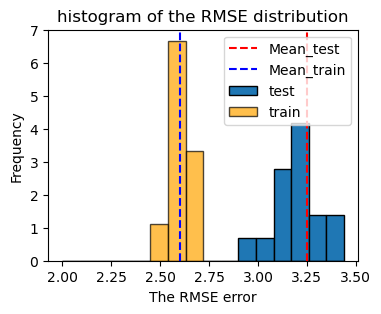

In [21]:
print("RMSE in total", "\n")
rmse_bin_plot(test_RMSE["all"], train_RMSE["all"], 2.0, 3.5, 0.09)

## Plot RMSE per bin

RMSE per bin 1


stdev_RMSE_test: 0.12
stdev_RMSE_train: 0.02
mean_RMSE_test: 0.97
mean_RMSE_train: 0.74


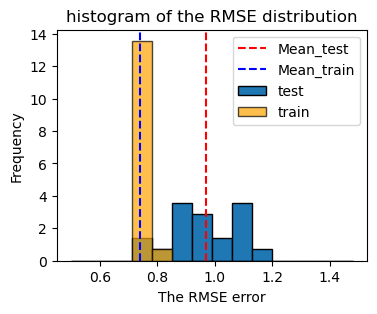

RMSE per bin 2


stdev_RMSE_test: 0.21
stdev_RMSE_train: 0.04
mean_RMSE_test: 1.91
mean_RMSE_train: 1.60


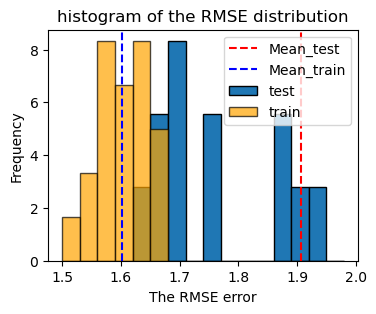

RMSE per bin 3


stdev_RMSE_test: 0.34
stdev_RMSE_train: 0.07
mean_RMSE_test: 4.93
mean_RMSE_train: 3.87


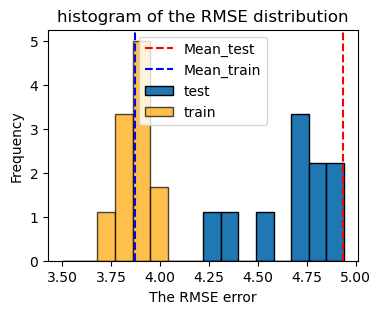

RMSE per bin 4


stdev_RMSE_test: 0.76
stdev_RMSE_train: 0.22
mean_RMSE_test: 14.86
mean_RMSE_train: 12.80


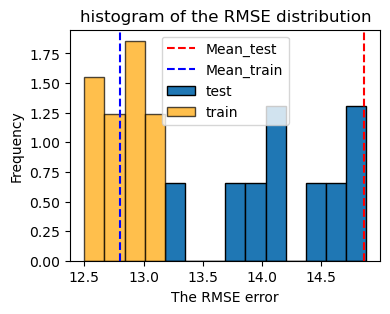

RMSE per bin 5


stdev_RMSE_test: 4.55
stdev_RMSE_train: 1.10
mean_RMSE_test: 36.56
mean_RMSE_train: 27.28


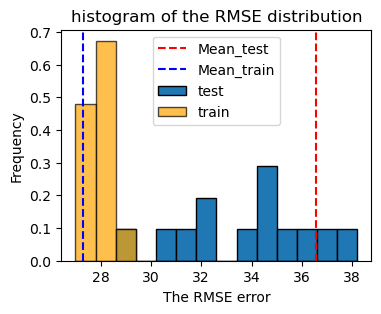

In [22]:
bin_params = {
    1: (0.5, 1.5, 0.07),
    2: (1.5, 2.0, 0.03),
    3: (3.5, 5.0, 0.09),
    4: (12.5, 15.0, 0.17),
    5: (27.0, 39.0, 0.8),
}


for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}\n")
    rmse_bin_plot(test_RMSE[bin_num], train_RMSE[bin_num], *bin_params[bin_num])